## Imports

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import jedi
import numpy as np
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pickle

from bokeh.plotting import figure, curdoc
from bokeh.models import Slider, ColumnDataSource, CDSView, IndexFilter, Plot, VBar, HoverTool
from bokeh.layouts import row, gridplot, layout #column
from bokeh.io import output_file, show, save
from bokeh.themes import Theme
from bokeh.palettes import viridis as palette
from bokeh.transform import factor_cmap


In [99]:
df = pd.read_csv('sales_predictions_clean.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [100]:
# sns.set_theme()
# seaborn_df = sns.load_dataset(df)
df.shape

(8523, 12)

In [101]:
df['Item_Identifier'].value_counts()

FDG33    10
FDW13    10
FDW26     9
NCJ30     9
NCI54     9
         ..
FDQ60     1
FDC23     1
FDE52     1
FDT35     1
FDY43     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [130]:
outlets = df['Outlet_Identifier'].unique()
outlets= list(outlets)
outlets

['OUT049',
 'OUT018',
 'OUT010',
 'OUT013',
 'OUT027',
 'OUT045',
 'OUT017',
 'OUT046',
 'OUT035',
 'OUT019']

In [103]:
for outlet in outlets:
    print(outlet, df[df['Outlet_Identifier'] == outlet]['Item_Visibility'].sum())

OUT049 56.549155617
OUT018 56.621454376
OUT010 56.308832139
OUT013 55.879859440000004
OUT027 54.804764293000005
OUT045 56.180779662999996
OUT017 56.834646144000004
OUT046 56.231875214
OUT035 56.974873359
OUT019 57.257041038000004


In [104]:
len(df[df['Outlet_Identifier'] == outlets[5]]['Item_Identifier'])

929

In [105]:
df[df['Outlet_Identifier'] == outlets[0]]['Item_Outlet_Sales'].sum()

2183969.8102

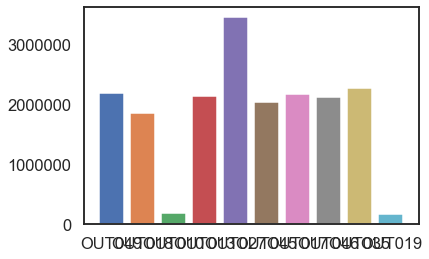

In [106]:
plt.plot(figsize = (10,50))

for outlet in outlets:
    plt.bar(x = outlet, height = df[df['Outlet_Identifier'] == outlet]['Item_Outlet_Sales'].sum())

    

lets plot that in seaborn

In [107]:
outlets
outlets_total_sales = []
for outlet in outlets:
    outlets_total_sales.append(df[df['Outlet_Identifier'] == outlet]['Item_Outlet_Sales'].sum())

outlets_total_sales

[2183969.8102,
 1851822.83,
 188340.17239999998,
 2142663.5782000003,
 3453926.0514,
 2036725.477,
 2167465.294,
 2118395.1682,
 2268122.9354,
 179694.09360000002]

In [128]:
outlets

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

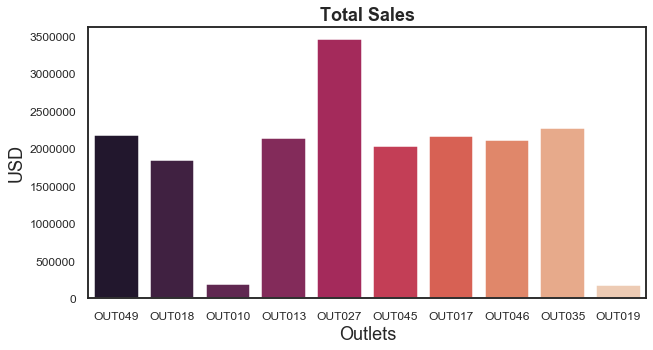

In [108]:
sns.set(style="white", context="talk")
f, ax = plt.subplots(1, figsize = (10,5))

sns.barplot(x=outlets, y=outlets_total_sales, palette="rocket")
ax.set_title('Total Sales', Fontweight = 'bold')
ax.set_xlabel('Outlets')
ax.set_ylabel('USD')

plt.xticks(Fontsize = 12)
plt.yticks(Fontsize = 12)
plt.show()

## Understanding Total Sales
looking at the plot above I notice two low outlyers and one high. I would like to see what is causing this. are they different types? sizes? or have a different location type? 

In [109]:
df[df['Outlet_Identifier'] == 'OUT019'].head(1)
# df[df['Outlet_Identifier'] == 'OUT027'].head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
23,FDC37,0.0,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876


In [110]:
df[(df['Outlet_Size'] == 'Small')]['Outlet_Location_Type'].value_counts()

Tier 2    2785
Tier 1    1458
Tier 3     555
Name: Outlet_Location_Type, dtype: int64

In [322]:
# list(palette.keys())

AttributeError: 'function' object has no attribute 'keys'

# BOKEH OUTLETS TOTAL SALES

In [248]:
# df_stores

# sorce = ColumnDataSource(df)
# sorce

outlets_data = {'outlets': outlets, 'total_sales': outlets_total_sales}
outlets_dataframe = pd.DataFrame(outlets_data)

outlets_dataframe
outlets_dataframe['total_sales'] = outlets_dataframe['total_sales'].round()
# outlets_dataframe['total_sales'] = outlets_dataframe['total_sales'].apply(lambda x: '%.5f' % x)
# outlets_dataframe['total_sales'].astype(float)

In [319]:
source = ColumnDataSource(outlets_dataframe)
# source
outlets_dataframe

fig_total_sales_outlets = figure(
    title='Total Sales for Outlets',
    # title_location= 'top left',
    toolbar_location= 'above',
    background_fill_color= '#EEEEEE',
    width_policy='max',
    x_axis_label='Outlets', 
    y_axis_label='USD',

    x_range=outlets
)

fig_total_sales_outlets.vbar(
    x='outlets', 
    top='total_sales', 
    source=source, 
    width=.9, 
    legend_field='outlets',
    fill_color=factor_cmap('outlets', palette= palette(15), factors=outlets),
    line_color='black',
    line_width=2,
    alpha=1)

fig_total_sales_outlets.add_tools(HoverTool(
    tooltips=[('Outlet', '@outlets'),('Total Sales', '@total_sales USD')], 
    attachment= 'vertical',
    ))

# show(fig_total_sales_outlets)
save(fig_total_sales_outlets, '../plots/fig_total_sales_outlets.html');

# BOKEH OUTLET TOTAL PRODUCT SALES

In [240]:
Spectral.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11])

In [182]:
df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


In [327]:
# df['Outlet_Identifer' == outlet[0]]
outlet_filter = df['Outlet_Identifier'] == outlets[0]
outlet0_Items = df[outlet_filter].drop(axis = 'columns', columns=['Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])
outlet0_Items['Item_Outlet_Sales'] = outlet0_Items['Item_Outlet_Sales'].round()
outlet0_Items['Units_Sold'] = (outlet0_Items['Item_Outlet_Sales'] / outlet0_Items['Item_MRP']).round()
outlet0_Items['Item_Visibility_Adjusted'] = outlet0_Items['Item_Visibility']*100

outlet0_Items['Item_Visibility'] = outlet0_Items['Item_Visibility'].round(5)
outlet0_Items_CDS = ColumnDataSource(outlet0_Items)

fig_outlet0_items_sales = figure(
    title='OUT049 Total Sales',
    # title_location= 'top left',
    toolbar_location= 'above',
    background_fill_color= '#EEEEEE',
    width_policy='max',
    x_axis_label='Item MRP', 
    y_axis_label='Total Sales USD'
    # x_range=outlets
)

fig_outlet0_items_sales.circle(
    x='Item_MRP', 
    y='Item_Outlet_Sales', 
    size='Item_Visibility_Adjusted',
    # size='Units_Sold',
    source=outlet0_Items_CDS, 
    # width=.9, 
    legend_field='Item_Type',
    legend_lo
    color=factor_cmap('Item_Type', palette= palette(16), factors=outlet0_Items.Item_Type),
    line_color='black',
    # line_width=2,
    alpha=.75,
    muted_alpha=.2
    )

fig_outlet0_items_sales.add_tools(HoverTool(
    tooltips=[
        ('Item', '@Item_Identifier'),
        ('Item Type', '@Item_Type'),
        ('Item Visibility', "@Item_Visibility"),
        ('Item MRP','@Item_MRP'), 
        ('Total Units Sold', '@Units_Sold'),
        ('Total Sales', '@Item_Outlet_Sales USD')
        ], 
    # attachment= 'vertical',
    ))

# fig_outlet0_items_sales.legend.click_policy="mute"

# show(fig_outlet0_items_sales)
save(fig_outlet0_items_sales, '../plots/fig_outlet0_items_sales.html');

In [307]:
outlet0_Items.Item_Type.value_counts()
outlet0_Items
# outlet0_Items.iloc[1]['Item_Outlet_Sales'] / outlet0_Items.iloc[1]['Item_MRP']
# outlet0_Items['Item_Outlet_Sales'] / outlet0_Items['Item_MRP']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Item_Outlet_Sales,Units_Sold,Size
0,FDA15,9.300,Low Fat,0.01605,Dairy,249.8092,3735.0,14.951411,1.604730
2,FDN15,17.500,Low Fat,0.01676,Meat,141.6180,2097.0,14.807440,1.676007
10,FDY07,11.800,Low Fat,0.00000,Fruits and Vegetables,45.5402,1516.0,33.289270,0.000000
12,FDX32,15.100,Regular,0.10001,Fruits and Vegetables,145.4786,1589.0,10.922569,10.001350
17,FDP49,9.000,Regular,0.06920,Breakfast,54.3614,718.0,13.207901,6.919638
...,...,...,...,...,...,...,...,...,...
8451,FDK21,7.905,Low Fat,0.01003,Snack Foods,249.6408,3254.0,13.034728,1.002789
8467,FDV31,9.800,LF,0.00000,Fruits and Vegetables,175.2370,3882.0,22.152856,0.000000
8470,FDW27,5.860,Regular,0.15109,Meat,155.1314,1551.0,9.997976,15.108785
8475,NCS17,18.600,Low Fat,0.08063,Health and Hygiene,92.5436,378.0,4.084561,8.062660
